In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


Prepare the data to be used with kNN

In [2]:
plots = [("traces/normal/", 'grid9_normal_2019-02-13_17:05'),
         ("traces/1bh-3/", 'grid9_1bh-3_2019-02-13_16:28'),
         ("traces/1bh-5/", 'grid9_1bh-5_2019-02-13_15:31'),
         ("traces/1bh-6/", 'grid9_1bh-6_2019-02-13_12:59'),
         ("traces/1bh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1bh-9/", 'grid9_1bh-9_2019-02-13_15:57'),
         ("traces/1gh-3/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-5/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-6/", 'grid_1gh-6_2019-02-15_18:25'),
         ("traces/1gh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1gh-9/", 'grid_1gh-9_2019-02-15_19:19')
        ]

stats = None

for row in plots:
    label = 'Normal'
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label)])
        
stats = stats.reset_index(drop=True)
stats.head(5)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7404:4:404:,141,339.276596,85174.044377,291.845926,2,106.0,1563.0,0.705,Normal
1,aaaa::212:7405:5:505:,178,392.123596,28083.058084,167.580005,3,197.0,1557.0,0.890,Normal
2,aaaa::212:7407:7:707:,151,486.913907,68843.959205,262.381324,3,214.0,1623.0,0.755,Normal
3,aaaa::212:7406:6:606:,176,315.613636,40342.752727,200.855054,2,129.0,1144.0,0.880,Normal
4,aaaa::212:740a:a:a0a:,181,497.646409,66065.140945,257.031401,4,260.0,1945.0,0.905,Normal


Select the set of features and labels that we use to fit the algorithm

In [3]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Black Hole', 'Gray Hole', 'Normal'}


Let us first observe the accuracies for different values of k

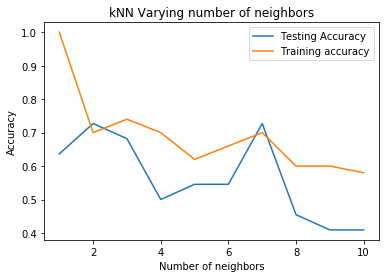

In [4]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [9]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 0.7272727272727273


               precision    recall  f1-score   support

  Black Hole       0.86      0.55      0.67        11
   Gray Hole       0.64      0.90      0.75        10
      Normal       1.00      1.00      1.00         1

   micro avg       0.73      0.73      0.73        22
   macro avg       0.83      0.82      0.81        22
weighted avg       0.77      0.73      0.72        22

